# Working with live data

In this tutorial we will explore how to work with live data when using the `gwrefpy`` package.

This notebook can be downloaded from the source code [here](https://github.com/andersretznerSGU/gwrefpy/blob/main/docs/turorials/livedata.ipynb).

We will cover the following topics:
1. Create some synthetic live data
2. Create a model and add wells
2. Fit the wells using the provided data
3. Update the wells with new data
4. Track the fit quality over time

## 1. Create some synthetic live data


In [1]:
import gwrefpy as gr
import pandas as pd
import numpy as np

ndays_init = 180 # initial data length
ndays_live = 365 # live data length
dates_init = pd.date_range(start="2020-01-01", periods=ndays_init, freq="D") # initial dates
dates_live = pd.date_range(start=dates_init[-1], periods=ndays_live, freq="D") # live dates

# create synthetic data
obs_init = pd.Series(5 + np.sin(np.linspace(0, 4 * np.pi, ndays_init)) + (np.random.normal(0, 0.1, ndays_init) * 2), index=dates_init)
ref_init = pd.Series(10 + np.sin(np.linspace(0, 4 * np.pi, ndays_init)) + np.random.normal(0, 0.1, ndays_init), index=dates_init)
obs_live = pd.Series(5 + np.sin(np.linspace(0, 6 * np.pi, ndays_live)) + (np.random.normal(0, 0.2, ndays_live) * 2), index=dates_live)
ref_live = pd.Series(10 + np.sin(np.linspace(0, 6 * np.pi, ndays_live)) + np.random.normal(0, 0.1, ndays_live), index=dates_live)


# 2. Create a model and add wells

In [2]:
well_obs = gr.Well(name="Observation well", is_reference=False, timeseries=obs_init)
well_ref = gr.Well(name="Reference well", is_reference=True, timeseries=ref_init)
model = gr.Model(name="Live data model")
model.add_well([well_obs, well_ref])

# 3. Fit the wells using the provided data

In [3]:
model.fit(well_obs, well_ref, offset="0D")

Fitting model 'Live data model' using reference well 'Reference well' and observation well 'Observation well'.


Statistic,Value,Description
RMSE,0.2466,Root Mean Square Error
R²,0.8853,Coefficient of Determination
R-value,0.9409,Correlation Coefficient
Slope,0.9532,Linear Regression Slope
Intercept,-4.5510,Linear Regression Intercept
P-value,0.0000,Statistical Significance
N,180,Number of Data Points
Std Error,0.2480,Standard Error
Confidence,95.0%,Confidence Level


We can also visualize the fit:

Plotting fit: Observation well ~ Reference well


(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Measurements'>)

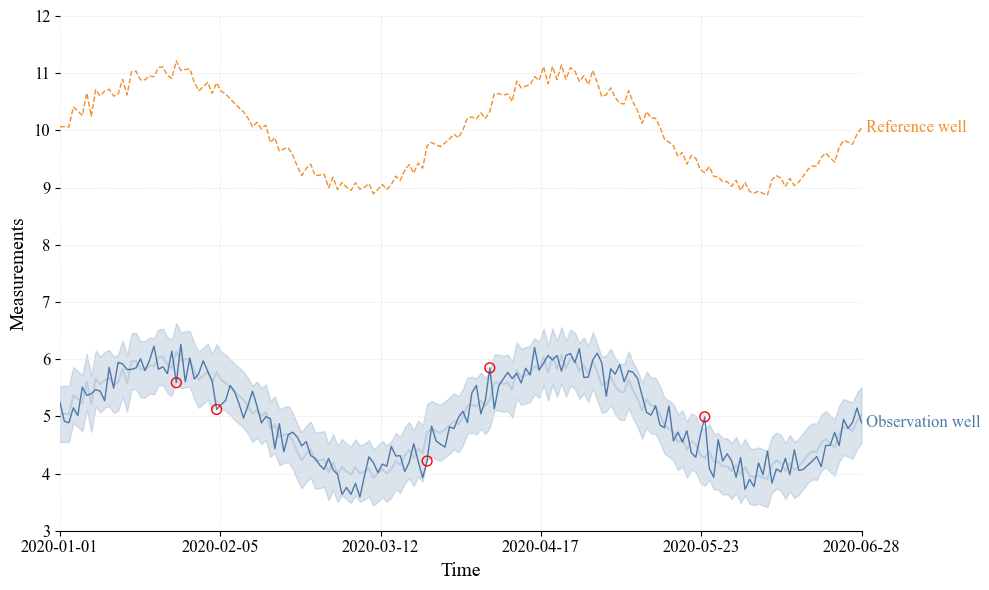

In [4]:
model.plot_fits(plot_style="fancy", color_style="color")

# 4. Update the wells with new data

In [5]:
well_obs.append_timeseries(obs_live)
well_ref.append_timeseries(ref_live)

We can now plot the updated data:

Plotting fit: Observation well ~ Reference well


(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Measurements'>)

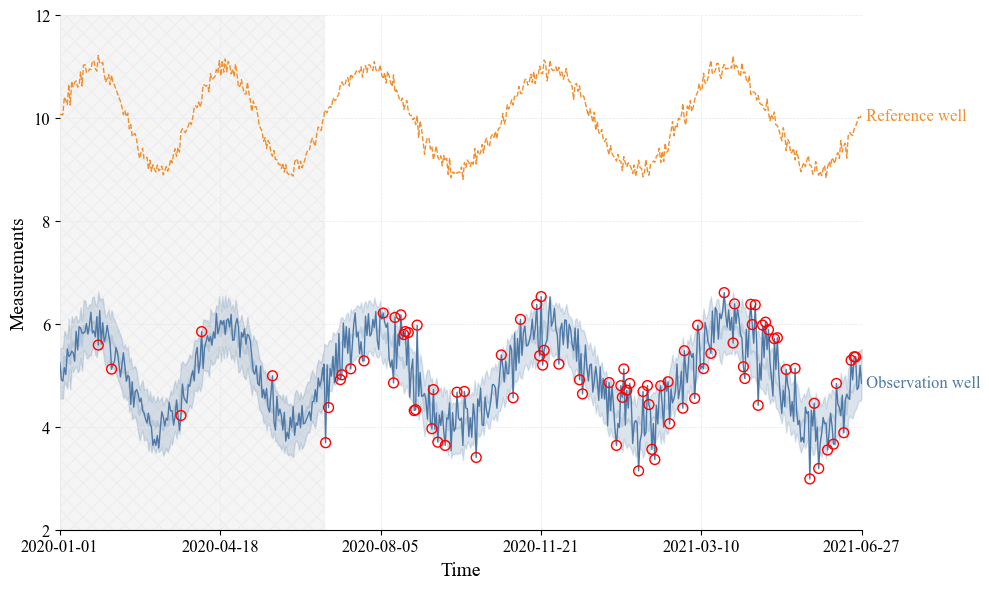

In [6]:
model.plot_fits(plot_style="fancy", color_style="color", show_initiation_period=True)